In [55]:
from pathlib import Path
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
from collections import Counter, OrderedDict
import pandas as pd

In [2]:
class ToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [3]:
transform = transforms.Compose([
    transforms.Resize((220, 220)),
    ToRGB(),
    transforms.ToTensor()
])

In [4]:
data_dir = Path('..', 'data')
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'

In [5]:
train_dataset = datasets.ImageFolder(train_dir, transform = transform)
# val_dataset = datasets.ImageFolder(val_dir)
len(train_dataset)

40

In [6]:
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size = batch_size)

In [7]:
classes = train_dataset.classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'crying')

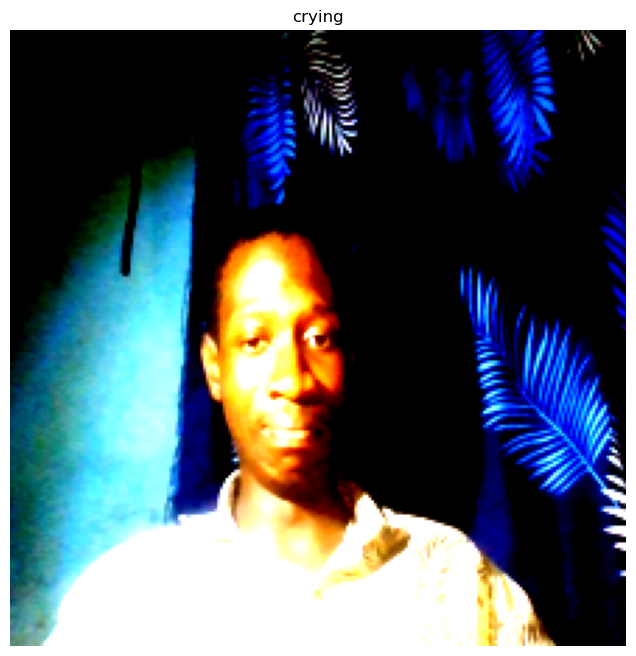

In [21]:
i = 5
ex = next(iter(train_loader))[0][i]
lbl = next(iter(train_loader))[1][i].item()
im = ex.permute(1, 2, 0).numpy()  # Shape: (220, 220, 3)

plt.figure(figsize=(10, 8)) 
plt.imshow(im)
plt.axis('off')
plt.title(classes[lbl])

In [9]:
def get_mean_std(loader):
    count, batchsum, squaredbatchsum = 0, 0, 0
    for data, _ in tqdm(loader):
        batchsum += torch.mean(data, dim = [0, 2, 3])
        squaredbatchsum += torch.mean(data **2, dim =  [0, 2, 3])
        count += 1
    
    mean = batchsum / count
    std = (squaredbatchsum / count - mean**2) ** 0.5
    
    return mean, std
mean, std = get_mean_std(train_loader)
print(f"mean: {mean}")
print(f"std: {std}")

  0%|          | 0/4 [00:00<?, ?it/s]

mean: tensor([0.2625, 0.3384, 0.4102])
std: tensor([0.2647, 0.2349, 0.2244])


In [10]:
norm_transform = transforms.Compose([
    transforms.Resize((220, 220)),
    ToRGB(),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])

In [11]:
train_dataset = datasets.ImageFolder(train_dir, transform = norm_transform)

In [12]:
g = torch.Generator()
g.manual_seed(45)

train_dataset, val_dataset = random_split(train_dataset, lengths = (0.8, 0.2), generator = g)
print(f"train length: {len(train_dataset)}")
print(f"test length: {len(val_dataset)}")

train length: 32
test length: 8


In [13]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    while isinstance(dataset, torch.utils.data.Subset):
        dataset = dataset.dataset
    class_to_index = dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

  0%|          | 0/32 [00:00<?, ?it/s]

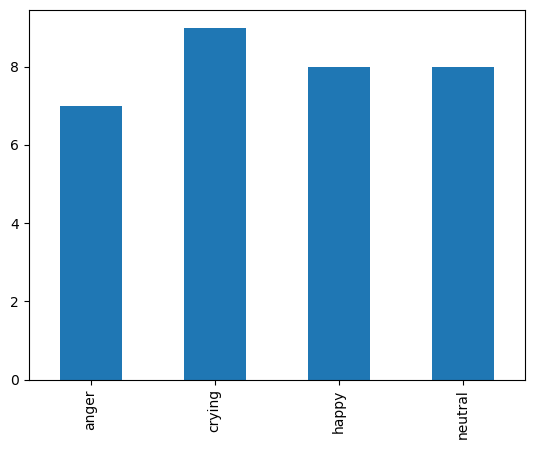

  0%|          | 0/8 [00:00<?, ?it/s]

<Axes: >

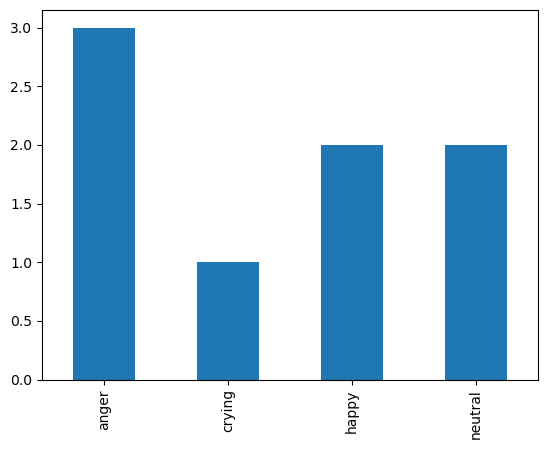

In [14]:
class_counts(train_dataset).plot(kind = 'bar')
plt.show()
class_counts(val_dataset).plot(kind = 'bar')

In [76]:
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)

In [77]:
model = torch.nn.Sequential(OrderedDict([
    ("conv1", torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=1, padding=1)),
    ("pool1", torch.nn.MaxPool2d(kernel_size=(2, 2))),
    ("relu1", torch.nn.ReLU()),
    ("conv2", torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3))),
    ("pool2", torch.nn.MaxPool2d(kernel_size=(2, 2))),
    ("relu2", torch.nn.ReLU()),
    ("conv3", torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3))),
    ("pool3", torch.nn.MaxPool2d(kernel_size=(2, 2))),
    ("relu3", torch.nn.ReLU()),
    ("flatten", torch.nn.Flatten()),
    ("fc", torch.nn.Linear(in_features=16 * 26 * 26, out_features=4))
]))


In [78]:
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 10

In [79]:
losses = []
for epoch in range(epochs):
    for data, labels in tqdm(train_loader):
        optim.zero_grad()

        output = model(data)
        loss = loss_fn(output, labels)

        loss.backward()
        optim.step()
        losses.append(loss.item())


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

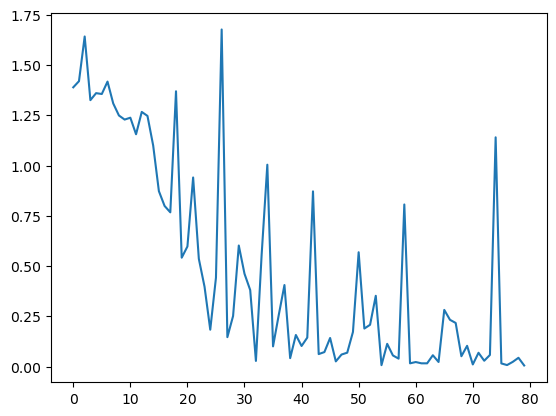

In [80]:
plt.plot(losses)

In [81]:
val_losses = []
val_accuracy = []
with torch.no_grad():
    count = 0
    for images, labels in tqdm(val_loader):
        output = model(images)
        count += 1
        loss = loss_fn(output, labels)
        val_losses.append(loss.item())
        print(count)

        correct = torch.eq(torch.argmax(output, dim = 1), labels)
        total_correct = torch.sum(correct).item()
        accuracy = total_correct / len(val_loader.dataset)
        val_accuracy.append(accuracy)

  0%|          | 0/2 [00:00<?, ?it/s]

1
2


In [82]:
len(val_loader)

2

[0.5519725680351257]

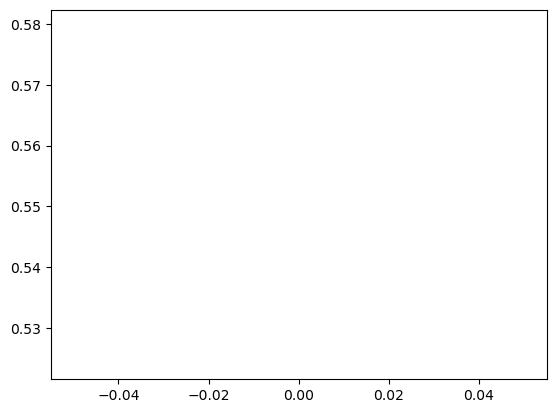

In [69]:
plt.plot(val_losses)
val_losses

In [63]:
accuracy

0.75